In [161]:
import pandahouse as ph 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# %matplotlib inline

In [162]:
# Connection settings to db
connection = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student', 
                  password='dpo_python_2020'
                 )

In [163]:
# Settings for seaborn
sns.set(
    font_scale = 2,
    style      = 'whitegrid',
    rc         = {'figure.figsize':(20,7)}
       )

In [21]:
# Downloading price data based on housing type
query = """
        SELECT 
            id,
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
        FROM ldn_listings
        ORDER BY id ASC
        LIMIT 1000
        """
df = ph.read_clickhouse(query, connection=connection)
df

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0
...,...,...,...
995,541081,Entire home/apt,110.0
996,541363,Entire home/apt,110.0
997,542231,Private room,65.0
998,542646,Entire home/apt,100.0


In [22]:
# Search 75th percentile of price for rooms of Private room type
df.groupby('room_type', as_index=False) \
  .price.quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [24]:
# Downloading housing rating data
query = """
        SELECT 
            id,
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
            toFloat32OrNull(review_scores_rating) AS review_scores_rating
        FROM ldn_listings
        WHERE review_scores_rating > 0
        ORDER BY id ASC
        """
df = ph.read_clickhouse(query, connection=connection)
df

,id,room_type,price,review_scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0
...,...,...,...,...
62117,43158660,Entire home/apt,160.0,100.0
62118,43164421,Entire home/apt,90.0,100.0
62119,43172018,Entire home/apt,300.0,100.0
62120,43185348,Entire home/apt,255.0,100.0


In [27]:
# Grouping the dataframe by housing type and calculating the average for price and rating
ax = df.groupby('room_type', as_index=False) \
       .agg({'price': 'mean', 'review_scores_rating': 'mean'})

In [28]:
ax

,room_type,price,review_scores_rating
0,Entire home/apt,154.840469,92.301765
1,Hotel room,272.145844,85.786461
2,Private room,53.526375,93.156013
3,Shared room,78.121040,87.198845


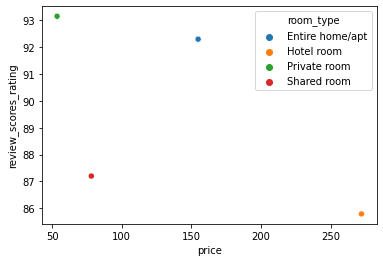

In [38]:
# Average price scatter plot
sns.scatterplot(x=ax.price, y=ax.review_scores_rating, hue=ax.room_type)

In [95]:
# Check what account verification methods the hosts used to offer different experiences
query = """
        SELECT
            DISTINCT
                host_id,
                host_verifications
        FROM ldn_listings
        WHERE experiences_offered != 'none'
        """
df = ph.read_clickhouse(query, connection=connection)

In [96]:
# Listing
df.host_verifications = df.host_verifications.apply(lambda x: x.strip('[]').replace("'","").split(', '))

In [98]:
# How many times each verification method occurs
df.host_verifications.explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [120]:
# For how many listings and in which neighborhoods did the hosts indicate impressions
query = """
        SELECT
            neighbourhood_cleansed,
            experiences_offered,
            count(experiences_offered != 'none') AS experiences_count
        FROM ldn_listings
        WHERE experiences_offered != 'none'
        GROUP BY neighbourhood_cleansed,
                 experiences_offered
        ORDER BY experiences_count DESC
        LIMIT 100
        """
df = ph.read_clickhouse(query, connection=connection)

In [122]:
df_pivot = df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

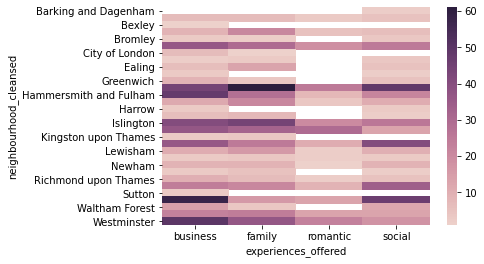

In [124]:
# Visualisation with heatmap
ax = sns.heatmap(df_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [130]:
# Downloading data on prices per night for different types of accommodation for which some type of experience is also available
query = """
        SELECT
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
        FROM ldn_listings
        WHERE experiences_offered != 'none'
        """
df = ph.read_clickhouse(query, connection=connection)

In [144]:
df.query("room_type=='Private room'").price

0        65.0
2       150.0
3        45.0
4        25.0
5        60.0
        ...  
1539     30.0
1540     60.0
1541    100.0
1542     30.0
1547     39.0
Name: price, Length: 613, dtype: float32

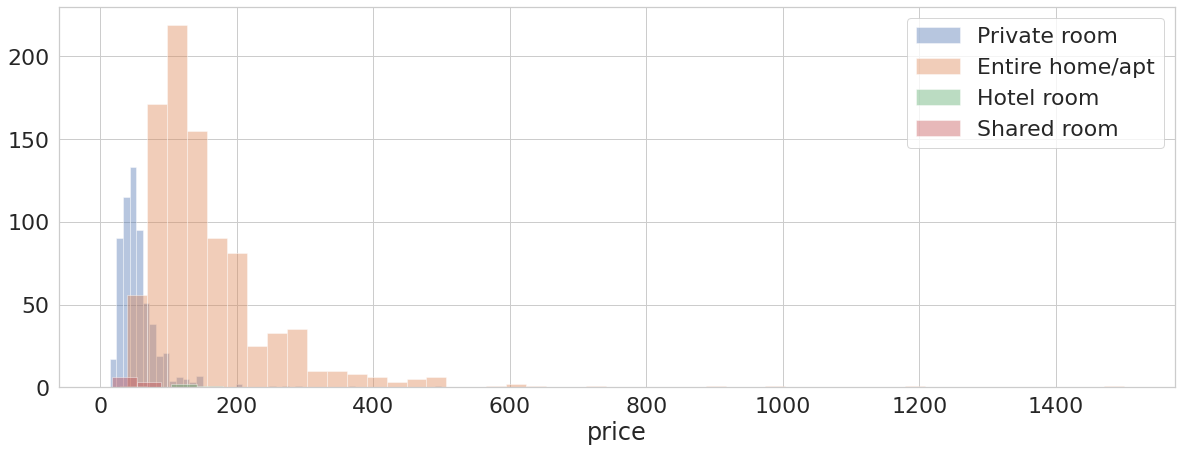

<Figure size 1440x504 with 0 Axes>

In [164]:
# Visualisation
sns.distplot(df.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()
sns.despine()

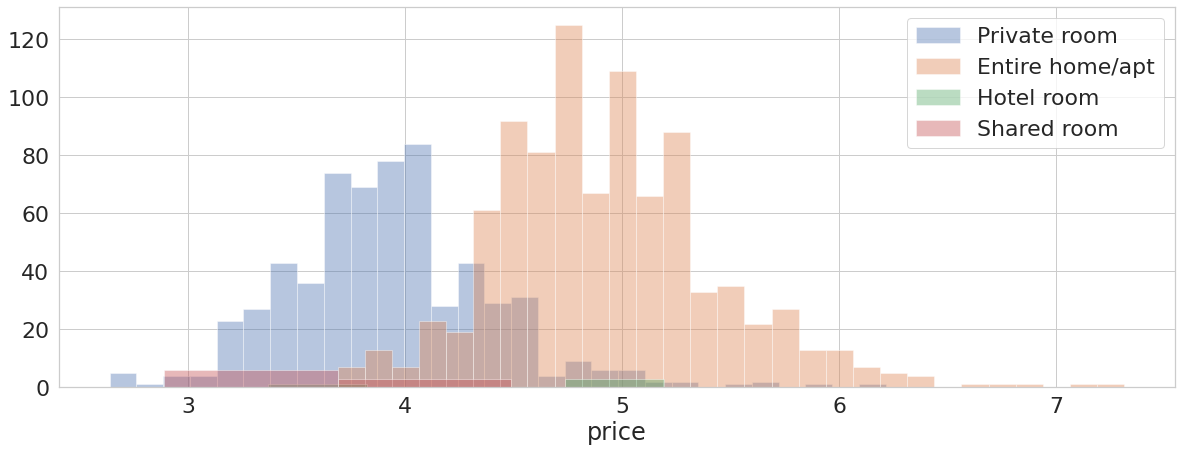

<Figure size 1440x504 with 0 Axes>

In [165]:
# Visualisation with logarithmisation
sns.distplot(np.log(df.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()
sns.despine()

In [175]:
# Download data on price, housing type, and date of first recall beginning January 2, 2010
query = """
        SELECT
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
            first_review
        FROM ldn_listings
        WHERE first_review > '2010-01-01'
        LIMIT 1000
        """
df = ph.read_clickhouse(query, connection=connection)

In [194]:
df.first_review = df.first_review.apply(lambda x: pd.to_datetime(x).year)

In [193]:
pd.to_datetime(df.first_review)[0].year

2010

In [199]:
df = df.groupby(['room_type', 'first_review'], as_index=False) \
        .agg({'price': 'mean'}) \
        .sort_values('first_review')

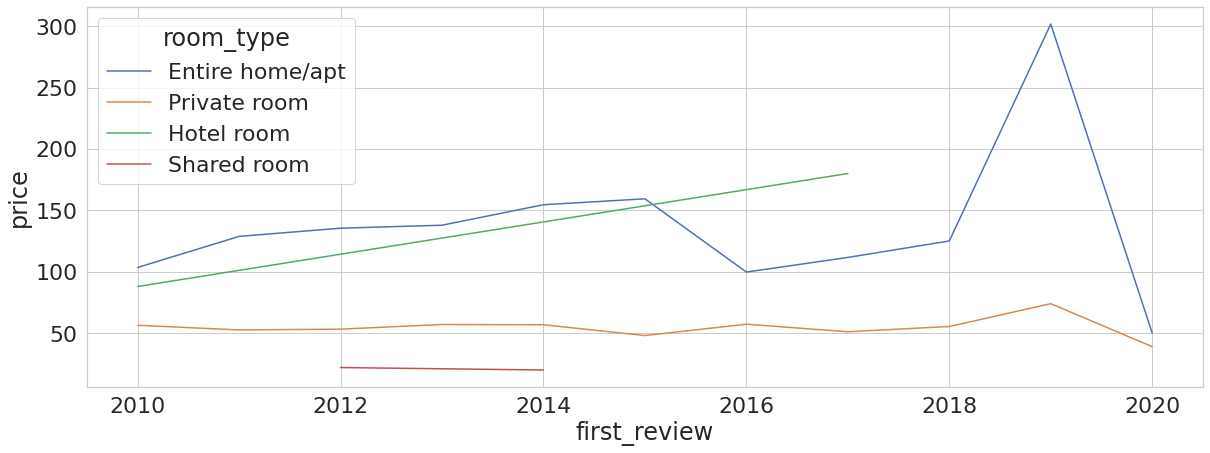

In [205]:
# Chart of dynamics of average housing prices depending on the type of room
sns.lineplot(x=df.first_review, y=df.price, hue=df.room_type)